# Compute derivatives and some stuff via Fourier transform

This code illustrates how to compute derivatives and some quantities associated with total-field anomalies via Fourier transform.

### Things we have to import

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
import matplotlib.pyplot as plt

In [2]:
from gravmag import rectangular_prism_fields as rpf
from gravmag import plot_functions as plf

### Model

In [3]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
inc, dec = 5, -45
magnetization = np.array([[1.4, inc, dec],
                          [1.3, inc, dec],
                          [1.1, inc, dec],
                          [1.2, inc, dec]])

# magnetization used to compute the true RTP of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
magnetization_vertical = np.array([[1.4, 90, 0],
                                   [1.3, 90, 0],
                                   [1.1, 90, 0],
                                   [1.2, 90, 0]])

### Points were we compute the synthetic data

In [4]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Main field

In [5]:
# reference point
yc, xc = 0, 1000

# coefficients I0
coeffs_I0 = [6, -1e-4, 3e-4, 1e-8, 1e-8]

# inclination (degrees)
I0 = coeffs_I0[0] + coeffs_I0[1]*(xp-xc) + coeffs_I0[2]*(yp-yc) + \
     coeffs_I0[3]*(xp-xc)*(xp-xc) + coeffs_I0[4]*(yp-yc)*(yp-yc)

# coefficients D0
coeffs_D0 = [45, 6e-5, 1e-4, 3e-9, 4e-9]

# declination (degrees)
D0 = coeffs_D0[0] + coeffs_D0[1]*(xp-xc) + coeffs_D0[2]*(yp-yc) + \
     coeffs_D0[3]*(xp-xc)*(xp-xc) + coeffs_D0[4]*(yp-yc)*(yp-yc)

# coefficients F0
coeffs_F0 = [23400, 1e-4, 1e-4, 0, 0]

# intensity (nT)
F0 = coeffs_F0[0] + coeffs_F0[1]*(xp-xc) + coeffs_F0[2]*(yp-yc) + \
     coeffs_F0[3]*(xp-xc)*(xp-xc) + coeffs_F0[4]*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

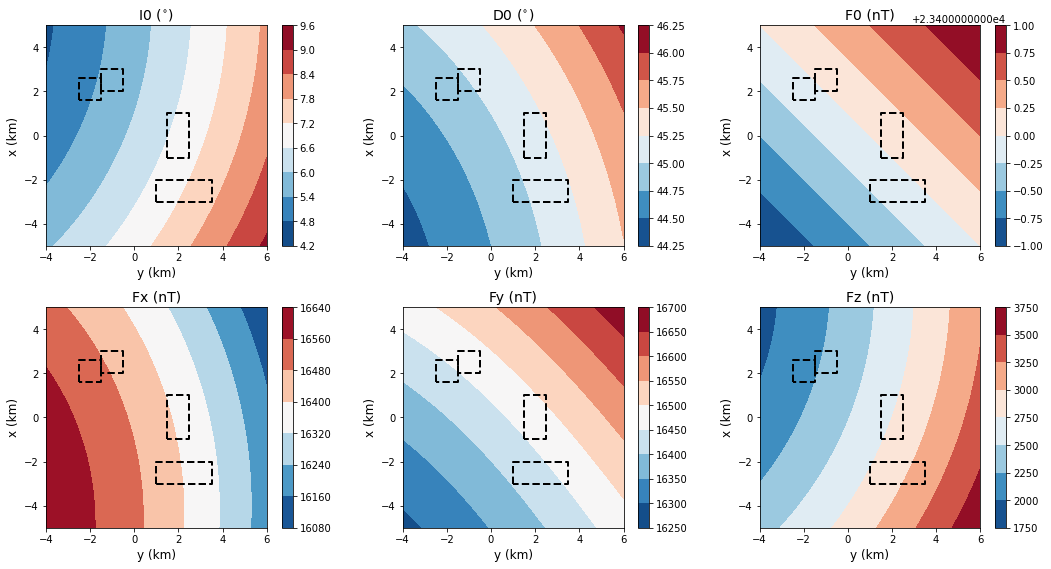

In [6]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic residual field

In [7]:
# Compute the magnetic field components
bx = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rpf.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

In [8]:
# Add a noise to the synthetic data
noise = np.random.normal(loc=0, scale=5, size=tfa.size)
approx_tfa += noise

### Derivatives of approximated TFA

In [9]:
# Compute spatial derivatives via forward modeling
delta = 10

# Shifted coordinates
coordinates_x_plus = coordinates.copy()
coordinates_x_plus[0] += delta
coordinates_x_minus = coordinates.copy()
coordinates_x_minus[0] -= delta

coordinates_y_plus = coordinates.copy()
coordinates_y_plus[1] += delta
coordinates_y_minus = coordinates.copy()
coordinates_y_minus[1] -= delta

# Compute the shifted magnetic induction components
bx_y_plus  = rpf.mag(coordinates=coordinates_y_plus, prisms=model, magnetization=magnetization, field='b_x')
by_y_plus  = rpf.mag(coordinates=coordinates_y_plus, prisms=model, magnetization=magnetization, field='b_y')
bz_y_plus  = rpf.mag(coordinates=coordinates_y_plus, prisms=model, magnetization=magnetization, field='b_z')
bx_y_minus = rpf.mag(coordinates=coordinates_y_minus, prisms=model, magnetization=magnetization, field='b_x')
by_y_minus = rpf.mag(coordinates=coordinates_y_minus, prisms=model, magnetization=magnetization, field='b_y')
bz_y_minus = rpf.mag(coordinates=coordinates_y_minus, prisms=model, magnetization=magnetization, field='b_z')

bx_x_plus  = rpf.mag(coordinates=coordinates_x_plus, prisms=model, magnetization=magnetization, field='b_x')
by_x_plus  = rpf.mag(coordinates=coordinates_x_plus, prisms=model, magnetization=magnetization, field='b_y')
bz_x_plus  = rpf.mag(coordinates=coordinates_x_plus, prisms=model, magnetization=magnetization, field='b_z')
bx_x_minus = rpf.mag(coordinates=coordinates_x_minus, prisms=model, magnetization=magnetization, field='b_x')
by_x_minus = rpf.mag(coordinates=coordinates_x_minus, prisms=model, magnetization=magnetization, field='b_y')
bz_x_minus = rpf.mag(coordinates=coordinates_x_minus, prisms=model, magnetization=magnetization, field='b_z')

deriv_y_approx_tfa = Fx_hat*(bx_y_plus - bx_y_minus)/delta**2 + \
                     Fy_hat*(by_y_plus - by_y_minus)/delta**2 + \
                     Fz_hat*(bz_y_plus - bz_y_minus)/delta**2

deriv_x_approx_tfa = Fx_hat*(bx_x_plus - bx_x_minus)/delta**2 + \
                     Fy_hat*(by_x_plus - by_x_minus)/delta**2 + \
                     Fz_hat*(bz_x_plus - bz_x_minus)/delta**2

In [10]:
horizontal_gradient_approx_tfa = np.sqrt(deriv_y_approx_tfa**2 + deriv_x_approx_tfa**2)

### Compute derivative via Fourier transform

In [11]:
# 2D Fourier transform of the TFA
F_tfa = fft2(approx_tfa.reshape(shape))

# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# Frequencies kx = 2pi fx, ky = 2pi fy
fx = fftfreq(n=shape[0], d=dx)
fy = fftfreq(n=shape[1], d=dy)
Ky, Kx = np.meshgrid(fy, fx)

# derivative filters
filter_deriv_x = 1j*Kx
filter_deriv_y = 1j*Ky

# Derivatives in Fourier
Fourier_deriv_x_approx_tfa = (ifft2(filter_deriv_x*F_tfa).real).ravel()
Fourier_deriv_y_approx_tfa = (ifft2(filter_deriv_y*F_tfa).real).ravel()

Fourier_horizontal_gradient_approx_tfa = np.sqrt(Fourier_deriv_y_approx_tfa**2 + Fourier_deriv_x_approx_tfa**2)

diff_deriv_x = Fourier_deriv_x_approx_tfa - deriv_x_approx_tfa
diff_deriv_y = Fourier_deriv_y_approx_tfa - deriv_y_approx_tfa
diff_horizontal_gradient = Fourier_horizontal_gradient_approx_tfa - horizontal_gradient_approx_tfa

### Plot the results

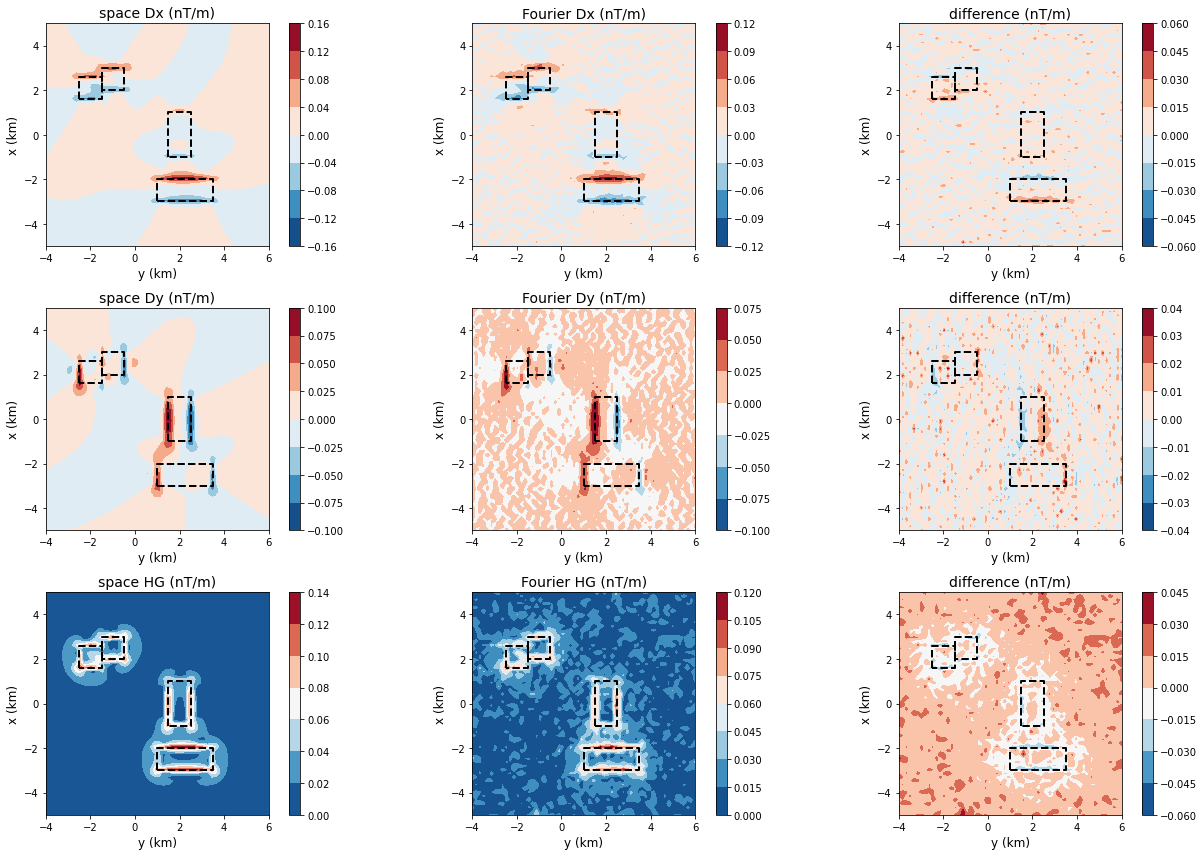

In [12]:
fields = [deriv_x_approx_tfa, Fourier_deriv_x_approx_tfa, diff_deriv_x,
          deriv_y_approx_tfa, Fourier_deriv_y_approx_tfa, diff_deriv_y,
          horizontal_gradient_approx_tfa, Fourier_horizontal_gradient_approx_tfa, diff_horizontal_gradient]
windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]
titles = ['space Dx (nT/m)', 'Fourier Dx (nT/m)', 'difference (nT/m)',
          'space Dy (nT/m)', 'Fourier Dy (nT/m)', 'difference (nT/m)',
          'space HG (nT/m)', 'Fourier HG (nT/m)', 'difference (nT/m)']

plt.figure(figsize=(18,12))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()